In [1]:
import numpy as np
import geopandas as gpd
import geopy.distance

import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

#from xhistogram.xarray import histogram
import dask.dataframe as dd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from fsspec.implementations.local import LocalFileSystem

from scipy import signal
import scipy.ndimage as im

from sympy import Symbol, pi, atan, factor, lambdify

#import mitequinox.plot as pl
#import mitequinox.sigp as sp

In [2]:
# Load data
region = 'atl'
root_dir = '/Users/zcaspar/codes/mit4320/'

df = pd.read_parquet(root_dir+'Lagrangian_data_'+region) # Lagrangian data

ds = xr.open_dataset(root_dir+'Eulerian_data_'+region+'.nc') # Eulerian data

In [3]:
df

,lon,lat,trajectory,waterdepth,zonal_velocity_demodulated_real,zonal_velocity_demodulated_imag
time,,,,,,
2011-11-15 00:00:00,-24.437500,-32.399822,4000268,0.000000,0.012321,-0.013189
2011-11-15 00:00:00,-40.187500,-24.455973,45000810,0.000000,0.020133,-0.008698
2011-11-15 00:00:00,-24.437500,-34.005707,4000266,0.000000,0.039356,-0.030185
2011-11-15 00:00:00,-30.687500,-26.204128,5000098,0.000000,-0.006489,0.017524
2011-11-15 00:00:00,-32.770832,-34.005707,4000066,0.000000,-0.003292,0.001102
...,...,...,...,...,...,...
2012-11-09 01:00:00,-10.136940,-33.209783,4000042,4000.315674,0.024667,-0.030264
2012-11-09 01:00:00,-16.452041,-26.076536,4001651,3683.949951,-0.008188,-0.017853
2012-11-09 01:00:00,-21.184572,-33.333357,44001107,4008.232178,0.008991,-0.011020


In [4]:
time = np.unique(df.index)
df = df.loc[time[::3]]

dfi = df.loc['2011-11':'2012-09']

<AxesSubplot:xlabel='time'>

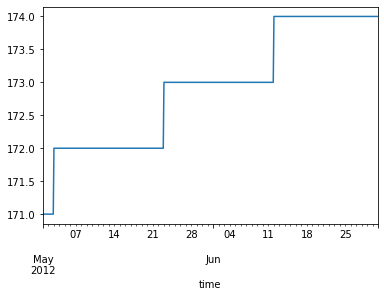

In [16]:
dfi.groupby(dfi.index).count().lon.loc['2012-05':'2012-06'].plot()

In [4]:
ds['SSU_rot_demodulated'] = ds['SSU_rot_demodulated_real'] + 1j*ds['SSU_rot_demodulated_imag']

In [5]:
dsi = ds#.isel(time=slice(0,None,2))

In [6]:
def remove_duplicates(df):
    """Find duplicates in dataframe and remove them.
    Create a column 'dt_flag', False if the dt is not different from 1/24
    
    ----------------
    Parameters
    df : dataframe from which duplicates must be removed, dataframe
    
    ----------------
    Returns
    df : input dataframe without duplicates and with new column 'dt_flag', dataframe
    """
#    df = df.reset_index().drop_duplicates('time').sort_values('time')#.set_index('time')
    df = df.drop_duplicates('time').set_index('time')
#    dt_df = df.index[1:]-df.index[:-1]
#    df['dt_flag'] = np.insert(dt_df!=np.timedelta64(1,'h'),0,False)
    return df

In [7]:
_df_sub = dfi.reset_index().groupby('trajectory').apply(remove_duplicates)

In [8]:
_df_sub = dfi.reset_index().set_index('time')#.drop(columns = 'trajectory')
_df_sub

,lon,lat,trajectory,waterdepth,zonal_velocity_demodulated_real,zonal_velocity_demodulated_imag
time,,,,,,
2011-11-15 00:00:00,-24.437500,-32.399822,4000268,0.000000,0.012321,-0.013189
2011-11-15 00:00:00,-40.187500,-24.455973,45000810,0.000000,0.020133,-0.008698
2011-11-15 00:00:00,-24.437500,-34.005707,4000266,0.000000,0.039356,-0.030185
2011-11-15 00:00:00,-30.687500,-26.204128,5000098,0.000000,-0.006489,0.017524
2011-11-15 00:00:00,-32.770832,-34.005707,4000066,0.000000,-0.003292,0.001102
...,...,...,...,...,...,...
2012-09-30 21:00:00,-13.425870,-32.767726,4000198,3129.340088,0.080604,0.028034
2012-09-30 21:00:00,-13.120845,-33.595305,4000296,3298.628418,0.043424,-0.027723
2012-09-30 21:00:00,-20.743388,-31.031851,5000073,4394.379883,0.055525,0.021648


In [9]:
np.unique(_df_sub.index).size
print(_df_sub.index[0],_df_sub.index[-1])
print(ds.time[0],ds.time[-1])

2011-11-15 00:00:00 2012-09-30 21:00:00
<xarray.DataArray 'time' ()>
array('2011-11-15T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    face     int64 ...
    time     datetime64[ns] 2011-11-15 <xarray.DataArray 'time' ()>
array('2012-09-30T21:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    face     int64 ...
    time     datetime64[ns] 2012-09-30T21:00:00


In [10]:
time_sub = np.unique(_df_sub.index)

In [11]:
latmin,latmax = dsi.lat.min(),dsi.lat.max()
lonmin,lonmax = dsi.lon.min(),dsi.lon.max()

In [12]:
flts_bin = _df_sub.where((_df_sub.lat<=latmax.values)&(_df_sub.lat>=latmin.values)
           &(_df_sub.lon<=lonmax.values)&(_df_sub.lon>=lonmin.values)
           )#.groupby('trajectory').count()

In [13]:
traj = np.unique(flts_bin.groupby('trajectory').count().lon.index)

In [14]:
print(flts_bin.groupby('trajectory').count().lon.values.size,traj.size)

138 138


In [15]:
time_bin = np.unique(flts_bin.index.values)

In [16]:
def distances(df): #,t0,t1
    #coords0 = (df.loc[t0].lat.values,df.loc[t0].lon.values)
    #coords1 = (df.loc[t1].lat.values,df.loc[t1].lon.values)
    time = np.unique(df.index.values)
    t0 = time[0]
    t1 = time[-1]
    latitudes = df.lat
    longitudes = df.lon
    dist_lat = geopy.distance.geodesic((latitudes.loc[t0],longitudes.loc[t0]),
                                       (latitudes.loc[t1],longitudes.loc[t0])).km
    dist_lon = geopy.distance.geodesic((latitudes.loc[t0],longitudes.loc[t0]),
                                       (latitudes.loc[t0],longitudes.loc[t1])).km
    dist_tot = geopy.distance.geodesic((latitudes.loc[t0],longitudes.loc[t0]),
                                       (latitudes.loc[t1],longitudes.loc[t1])).km
    df_out = pd.DataFrame(data={'dlat':dist_lat,'dlon':dist_lon,'dl':dist_tot},index = df.trajectory)
    #df['dlat'] = dist_lat
    #df['dlon'] = dist_lon
    return df_out#dist_lat,dist_lon

In [17]:
dist_sub = (_df_sub.groupby('trajectory').apply(distances).reset_index(level=[1])
           ).drop(columns='trajectory').drop_duplicates()

dist_bin = (flts_bin.groupby('trajectory').apply(distances).reset_index(level=[1])
           ).drop(columns='trajectory').drop_duplicates()

### Figures

In [18]:
def clustering(traj):
    cut = np.where(np.diff(traj)>1e5)[0]
    groups = [(traj[0],traj[cut[0]])]
    print(cut)
#    if cut.size>1:
    for i,c in enumerate(cut[:-1]):
        groups.append((traj[c+1],traj[cut[i+1]]))
    groups.append((traj[cut[-1]+1],traj[-1]))
    return groups

In [19]:
clusters = clustering(traj)
clusters

[ 86 103 133]


[(4000017.0, 4002245.0),
 (5000000.0, 5000599.0),
 (44000871.0, 44001677.0),
 (45000810.0, 45000860.0)]

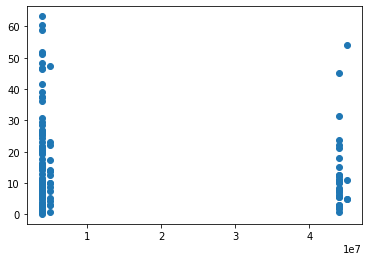

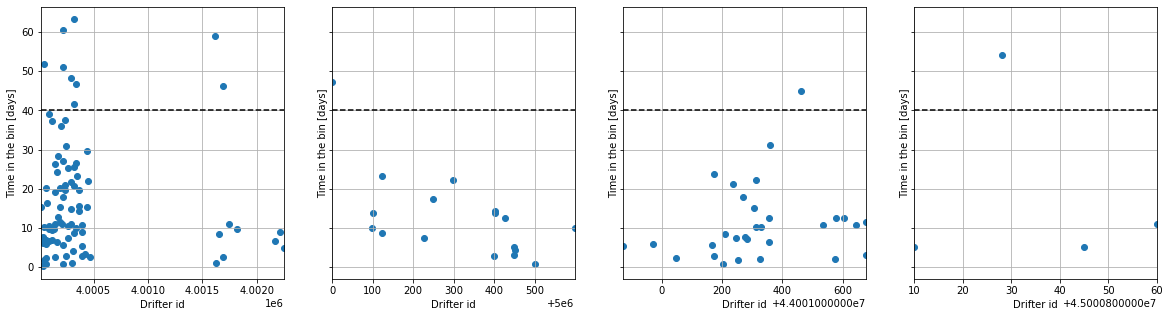

In [20]:
plt.scatter(traj,flts_bin.groupby('trajectory').count().lon.values/24*3)
fig,axs = plt.subplots(1,len(clusters),figsize=(5*(len(clusters)),5),sharey=True)
for c,ax in zip(clusters,axs):
    ax.scatter(traj,flts_bin.groupby('trajectory').count().lon.values/24*3);
    ax.set_xlim(c[0],c[-1])
    ax.grid();ax.axhline(40,linestyle='--',c='k');
    ax.set_ylabel('Time in the bin [days]');ax.set_xlabel('Drifter id')

#ax = axs[1]
#ax.scatter(traj,flts_bin.groupby('trajectory').count().lon.values/24*3);
#ax.set_xlim(3.6e7,3.6003e7);
#ax.grid();ax.axhline(40,linestyle='--',c='k');
#ax.set_ylabel('Time in the bin [days]');ax.set_xlabel('Drifter id')

In [21]:
timein = flts_bin.groupby('trajectory').count().lon/24*3

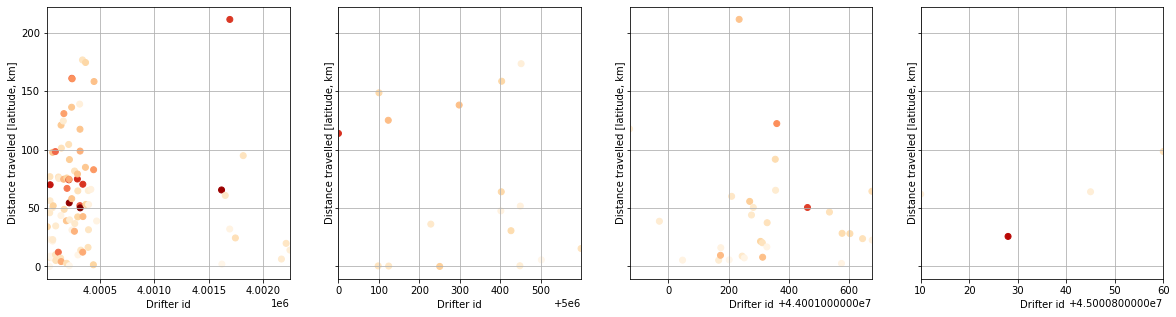

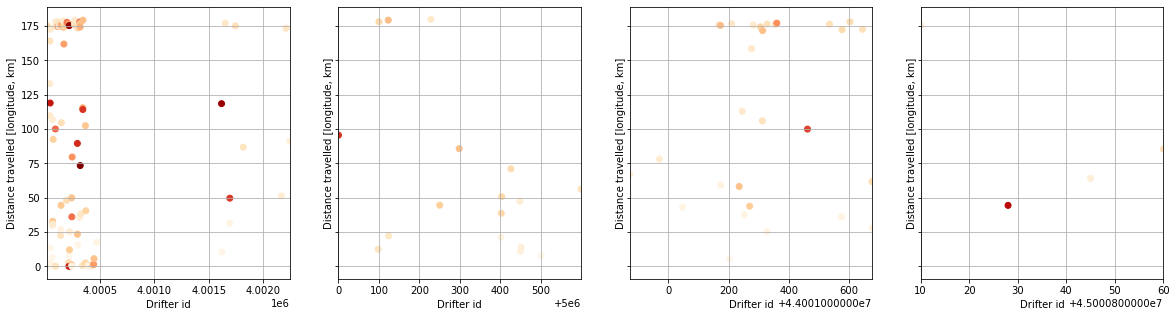

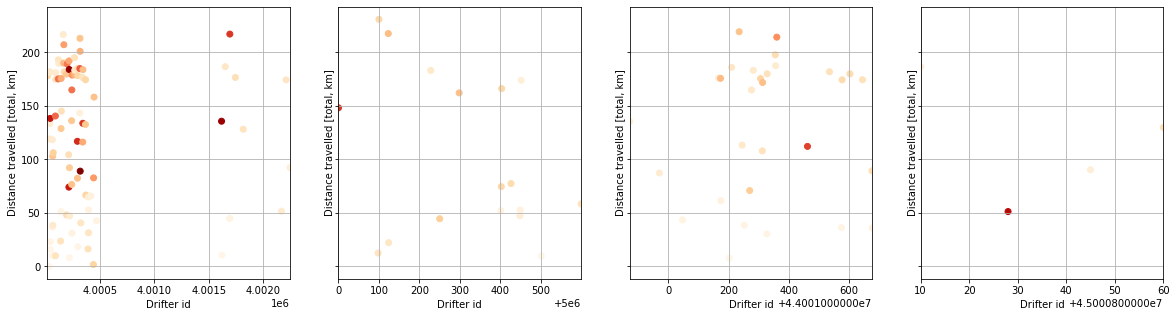

In [22]:
_ = dist_bin.index
fig,axs = plt.subplots(1,len(clusters),figsize=(5*(len(clusters)),5),sharey=True)
for c,ax in zip(clusters,axs):
    ax.scatter(_,dist_bin.dlat.values,c=timein.loc[_].values,cmap='OrRd');
    ax.set_xlim(c[0],c[-1])
    ax.grid()#;ax.axhline(40,linestyle='--',c='k');
    ax.set_ylabel('Distance travelled [latitude, km]');ax.set_xlabel('Drifter id')
    
fig,axs = plt.subplots(1,len(clusters),figsize=(5*(len(clusters)),5),sharey=True)
for c,ax in zip(clusters,axs):
    ax.scatter(_,dist_bin.dlon.values,c=timein.loc[_].values,cmap='OrRd');
    ax.set_xlim(c[0],c[-1])
    ax.grid()#;ax.axhline(40,linestyle='--',c='k');
    ax.set_ylabel('Distance travelled [longitude, km]');ax.set_xlabel('Drifter id')
    
fig,axs = plt.subplots(1,len(clusters),figsize=(5*(len(clusters)),5),sharey=True)
for c,ax in zip(clusters,axs):
    ax.scatter(_,dist_bin.dl.values,c=timein.loc[_].values,cmap='OrRd');
    ax.set_xlim(c[0],c[-1])
    ax.grid()#;ax.axhline(40,linestyle='--',c='k');
    ax.set_ylabel('Distance travelled [total, km]');ax.set_xlabel('Drifter id')

In [23]:
_ = dist_sub.index
clusters = clustering(_)
clusters

[ 97 120 165]


[(4000017, 4002245),
 (5000000, 5000599),
 (44000871, 44001677),
 (45000803, 45000860)]

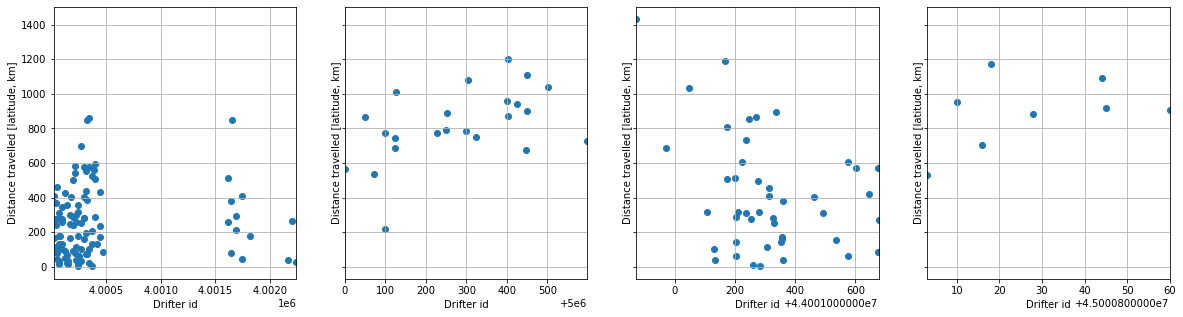

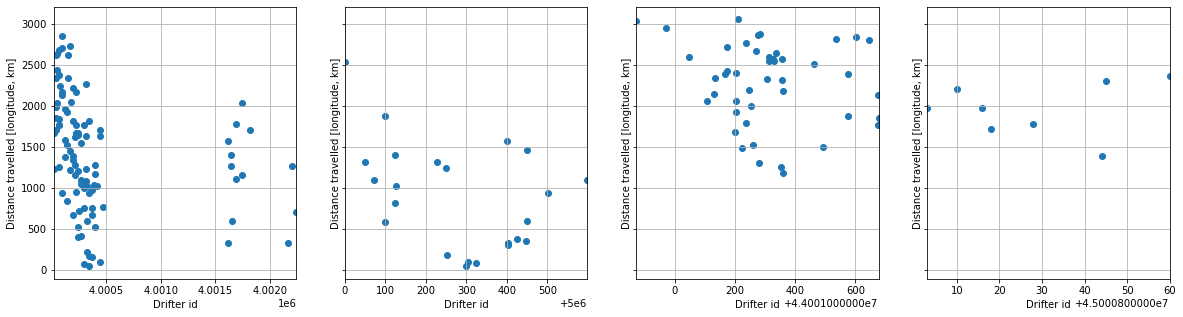

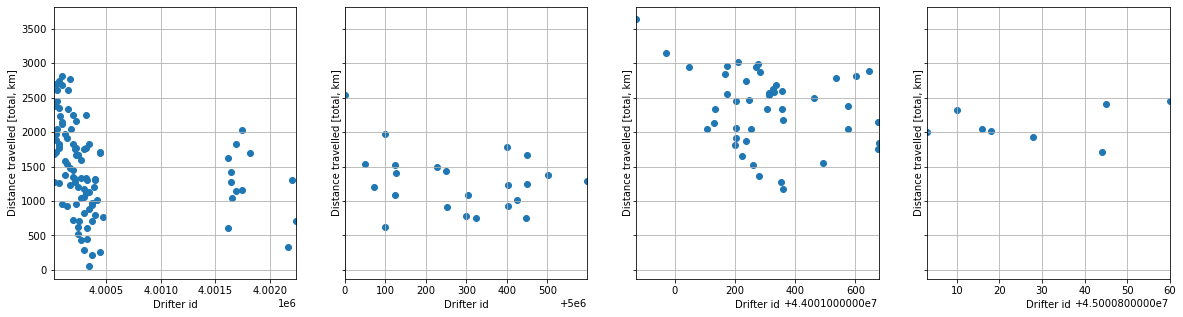

In [24]:

fig,axs = plt.subplots(1,len(clusters),figsize=(5*(len(clusters)),5),sharey=True)
for c,ax in zip(clusters,axs):
    ax.scatter(_,dist_sub.dlat.values);
    ax.set_xlim(c[0],c[-1])
    ax.grid()#;ax.axhline(40,linestyle='--',c='k');
    ax.set_ylabel('Distance travelled [latitude, km]');ax.set_xlabel('Drifter id')
    
fig,axs = plt.subplots(1,len(clusters),figsize=(5*(len(clusters)),5),sharey=True)
for c,ax in zip(clusters,axs):
    ax.scatter(_,dist_sub.dlon.values);
    ax.set_xlim(c[0],c[-1])
    ax.grid()#;ax.axhline(40,linestyle='--',c='k');
    ax.set_ylabel('Distance travelled [longitude, km]');ax.set_xlabel('Drifter id')
    
fig,axs = plt.subplots(1,len(clusters),figsize=(5*(len(clusters)),5),sharey=True)
for c,ax in zip(clusters,axs):
    ax.scatter(_,dist_sub.dl.values);
    ax.set_xlim(c[0],c[-1])
    ax.grid()#;ax.axhline(40,linestyle='--',c='k');
    ax.set_ylabel('Distance travelled [total, km]');ax.set_xlabel('Drifter id')

In [25]:

import pyinterp
def interp_bis(_df,ds,v):
#    with dask.config.set(schedulers='threads'):
#    ds = xr.open_zarr(ut.work_data_dir+'filtered_itide/SSU_filtered.zarr')
        #ds = ds.isel(i=slice(0,None,1))
#    grd = xr.open_zarr(ut.work_data_dir+'rechunked/SSU_rot.zarr')[['XC','YC']]
#    ds = xr.merge([ds,grd])#.isel(i=slice(0,None,2),j=slice(0,None,2))
    t = np.unique(_df.index)
    _dsi = ds[['XC','YC',v]].sel(time=t)#.load()
    var = (np.abs(_dsi[v].values)**2)
    mesh = pyinterp.RTree()
        #print(_dsi.XC.shape)
    mesh.packing(np.vstack((_dsi.XC.values.flatten(), 
                            _dsi.YC.values.flatten())).T,
                        var.flatten()
                        )
    idw_eta, neighbors = mesh.inverse_distance_weighting(
                            np.vstack((_df.lon, _df.lat)).T, #[:]
                            within=True,
                            radius=5e5,
#                            k=,  
                            num_threads=1)
#    print(idw_eta,neighbors)
    _df[v+'_interp'] = idw_eta
    return _df

In [26]:
df_04 = flts_bin.loc['2012-04':'2012-05-10'].dropna() #_df_sub

In [27]:
df_04['zonal_velocity_demodulated'] = df_04['zonal_velocity_demodulated_real']+1j*df_04['zonal_velocity_demodulated_imag']

In [28]:
ds_04 = dsi.sel(time=slice('2012-04','2012-05-10'))

In [29]:
df_04_interp = df_04.groupby(df_04.index).apply(interp_bis,ds_04,'SSU_rot_demodulated')

In [30]:
group_id = df_04_interp.groupby('trajectory').count().idxmax().values[0]
_df = df_04_interp.groupby('trajectory').get_group(group_id)
_df

,lon,lat,trajectory,waterdepth,zonal_velocity_demodulated_real,zonal_velocity_demodulated_imag,zonal_velocity_demodulated,SSU_rot_demodulated_interp
time,,,,,,,,
2012-04-01 00:00:00,-21.558974,-33.664948,4000242.0,3845.866455,0.097712,0.005983,0.097712+0.005983j,0.016557
2012-04-01 03:00:00,-21.600768,-33.667076,4000242.0,3901.040039,0.094515,0.007099,0.094515+0.007099j,0.014901
2012-04-01 06:00:00,-21.621764,-33.690796,4000242.0,3901.040039,0.091296,0.008212,0.091296+0.008212j,0.009776
2012-04-01 09:00:00,-21.627223,-33.706926,4000242.0,3867.300537,0.088115,0.009307,0.088115+0.009307j,0.007721
2012-04-01 12:00:00,-21.637229,-33.703445,4000242.0,3867.300537,0.085024,0.010369,0.085024+0.010369j,0.007169
...,...,...,...,...,...,...,...,...
2012-04-28 12:00:00,-20.208643,-32.590561,4000242.0,3846.344238,-0.000710,0.014946,-0.000710+0.014946j,0.003405
2012-04-28 15:00:00,-20.188793,-32.568822,4000242.0,3855.784912,-0.000740,0.019560,-0.000740+0.019560j,0.004745
2012-04-28 18:00:00,-20.170605,-32.555785,4000242.0,3869.277344,-0.000388,0.024531,-0.000388+0.024531j,0.005852


In [31]:
tmid = _df.index[0]+(_df.index[-1]-_df.index[0])//2#'2012-04-20 00:00:00'
latmid,lonmid = _df.iloc[_df.index.get_loc(tmid,method='nearest')].lat,_df.iloc[_df.index.get_loc(tmid,method='nearest')].lon
#_df.loc[tmid].lat,_df.loc[tmid].lon

/var/folders/8p/ctkm_wt55j54lh09mdw3yv0r00g___/T/ipykernel_18432/3286033982.py:2: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  latmid,lonmid = _df.iloc[_df.index.get_loc(tmid,method='nearest')].lat,_df.iloc[_df.index.get_loc(tmid,method='nearest')].lon


In [32]:
time = np.unique(_df.index.values)

In [33]:
_ds = ds_04.sel(lon=lonmid,lat=latmid,method='nearest')

/opt/anaconda3/envs/croco/lib/python3.8/site-packages/xarray/core/utils.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  label = np.asarray(label, dtype=coords_dtype)


In [34]:
time_id = _df.index

In [35]:
interp = []
for idx in range(_df.index.size):
    #idx = 0
    _ = _df.iloc[idx]
    loni,lati = _.lon,_.lat
    _s = ds_04.sel(lon=loni,lat=lati,method='nearest').isel(time=idx)
    interp.append(_s.SSU_rot_demodulated.values)

/opt/anaconda3/envs/croco/lib/python3.8/site-packages/xarray/core/utils.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  label = np.asarray(label, dtype=coords_dtype)
/opt/anaconda3/envs/croco/lib/python3.8/site-packages/xarray/core/utils.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  label = np.asarray(label, dtype=coords_dtype)
/opt/anaconda3/envs/croco/lib/python3.8/site-packages/xarray/core/utils.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  label = np.asarray(label, dtype=coords_dtype)
/opt/anaconda3/envs/croco/lib/python3.8/site-packages/xarray/core/utils.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  label = np.asarray(label, dtype=coords_dtype)
/opt/anaconda3/envs/croco/lib/python3.8/site-packages/xarray/core/utils.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  label = np.asarray(label, dtype=coor

/opt/anaconda3/envs/croco/lib/python3.8/site-packages/xarray/core/utils.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  label = np.asarray(label, dtype=coords_dtype)
/opt/anaconda3/envs/croco/lib/python3.8/site-packages/xarray/core/utils.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  label = np.asarray(label, dtype=coords_dtype)
/opt/anaconda3/envs/croco/lib/python3.8/site-packages/xarray/core/utils.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  label = np.asarray(label, dtype=coords_dtype)
/opt/anaconda3/envs/croco/lib/python3.8/site-packages/xarray/core/utils.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  label = np.asarray(label, dtype=coords_dtype)
/opt/anaconda3/envs/croco/lib/python3.8/site-packages/xarray/core/utils.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  label = np.asarray(label, dtype=coor

/opt/anaconda3/envs/croco/lib/python3.8/site-packages/xarray/core/utils.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  label = np.asarray(label, dtype=coords_dtype)
/opt/anaconda3/envs/croco/lib/python3.8/site-packages/xarray/core/utils.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  label = np.asarray(label, dtype=coords_dtype)
/opt/anaconda3/envs/croco/lib/python3.8/site-packages/xarray/core/utils.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  label = np.asarray(label, dtype=coords_dtype)
/opt/anaconda3/envs/croco/lib/python3.8/site-packages/xarray/core/utils.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  label = np.asarray(label, dtype=coords_dtype)
/opt/anaconda3/envs/croco/lib/python3.8/site-packages/xarray/core/utils.py:74: ComplexWarning: Casting complex values to real discards the imaginary part
  label = np.asarray(label, dtype=coor

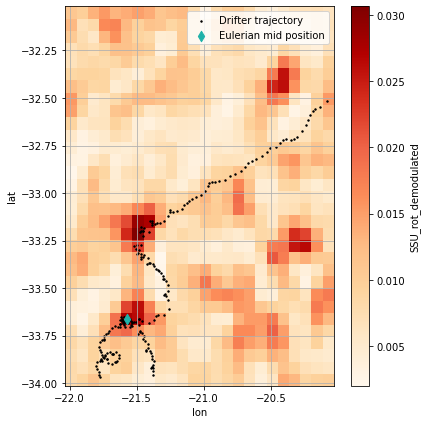

In [36]:
savefig=True
fig,ax = plt.subplots(figsize=(6,6))
(np.abs(ds_04.SSU_rot_demodulated)**2).mean('time').plot(ax=ax,y='lat',cmap='OrRd')
ax.scatter(_df.lon,_df.lat,c='k',s=2,label='Drifter trajectory');
ax.scatter(_ds.lon,_ds.lat,c='lightseagreen',marker='d',s=55,label='Eulerian mid position')
ax.grid();ax.set_title('');ax.legend()
if savefig:
    fig.tight_layout()
    fig.savefig('/Users/zcaspar/Videos/'+region+'_traj.pdf')

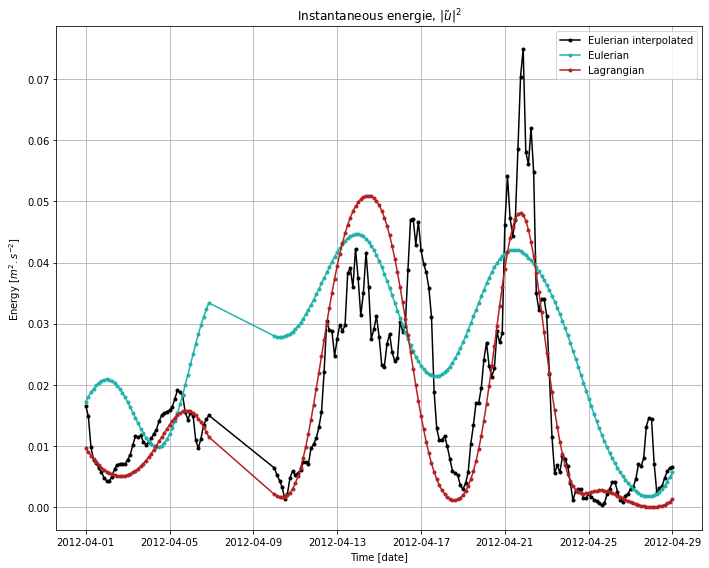

In [37]:
fig,ax = plt.subplots(figsize=(10,8))
ax.plot(time_id,(_df.SSU_rot_demodulated_interp.values)
        ,marker='.',c='k',label='Eulerian interpolated')
ax.plot(time_id,(np.abs(_ds.SSU_rot_demodulated.sel(time=time_id))**2)
        ,marker='.',c='lightseagreen',label='Eulerian')
ax.plot(time_id,(np.abs(_df.zonal_velocity_demodulated.values)**2)
        ,marker='.',c='firebrick',label='Lagrangian')

ax.grid();ax.legend();
ax.set_ylabel(r'Energy [$m^2.s^{-2}$]');ax.set_xlabel('Time [date]');
ax.set_title(r'Instantaneous energie, $\vert \tilde u \vert^2$')
if savefig:
    fig.tight_layout()
    fig.savefig('/Users/zcaspar/Videos/'+region+'_interp.pdf')

In [38]:
_sinterp = np.array([a for a in interp])

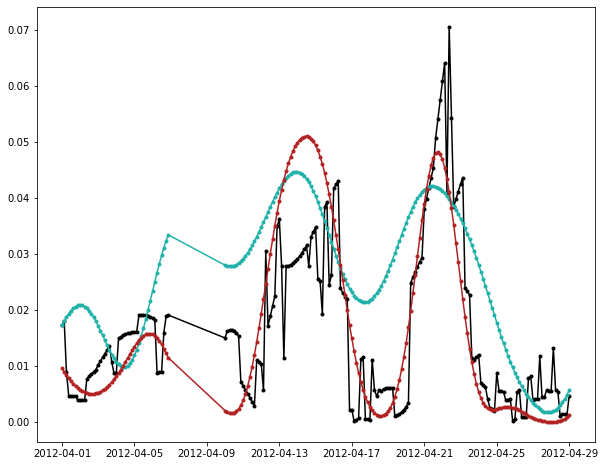

In [39]:
fig,ax = plt.subplots(figsize=(10,8))
ax.plot(time_id,(np.abs(_sinterp)**2)
        ,marker='.',c='k',label='Eulerian interpolated')
ax.plot(time_id,(np.abs(_ds.SSU_rot_demodulated.sel(time=time_id))**2)
        ,marker='.',c='lightseagreen',label='Eulerian')
ax.plot(time_id,(np.abs(_df.zonal_velocity_demodulated.values)**2)
        ,marker='.',c='firebrick',label='Lagrangian')